# 8.3 使用预训练模型

解决小型数据集问题,一个非常重要的做法是使用预训练模型加以调整.

预训练模型通常是在一个非常大而全的原始数据集上训练,那么模型的深层信息有可能是对视觉世界的通用模型.例如一个 imageNet 上训练的模型(动物/日常物品)可用用来识别家具物品等完全不同的问题.这样的深层可移植 可复制,是深度学习对之前浅度学习的一大优势.

这里选择的是在 imageNet 上训练的 cnn 模型,imageNet 包含 140 万张标记的图片和 1000 多给标签,其中也包含了许多不同种类的猫/狗,我们是可以期待使用 imageNet 训练出的模型效果.

本章使用的 VGG16 模型,是 2014 年 Karen Simonyan 和 Andrew Zisserman 开发的.虽然截止到今日,VGG16 是比较旧的模型,其效果不仅无法和最新的模型相比,VGG16 还要更加复杂.但是 VGG16 的架构和我们依旧熟悉的架构非常相似,方便我们理解.

像是 VGG, ResNet, Inception, Xception 这样的模型名称,我们还好见到很多很多..

预训练的网络有两者使用方式,我们都会见到

- 特征提取
- 微调模型


## 特征提取

特征提取是使用预处理模型的一部分 cnn,提取特征,再在其后添加新的全连接层,重新训练.

如前面的例子,典型的图片分类包括两个部分

- cnn 层,包括一系列的 cnn 和池化层.
- 全连接层,用于最后的输出.

特征提取即复用预处理模型的 cnn 层,重新训练新的全连接层.

![swapping_fc_classifier](swapping_fc_classifier.png)

为何只复用 cnn 却舍弃了密集层?

- cnn 学到的特征比密集层更加通用.密集层学习到的特征是关联到原模型训练数据的存在概率,cnn 层的特征图是图片的特征,因此更加通用.
- cnn 的特征图本身就是包含了输入图像的位置信息,而密集层并不包含.

注意: 不同深度的 cnn 层,其通用性也是不同的.越靠近底层提取的是局部高度通用的特征图(视觉边缘/纹理/颜色等).而靠近顶部层提取的是更加抽象概念(猫耳,狗眼等),如果数据集和原模型的数据集差异很大,最好只复用预处理模型的前几层.

ImageNet 已经包含了很多猫跟狗的类别,复用密集层有可能是有益的.但是这里选择更普遍的情况,复用 cnn 层,重新训练密集层.这里使用 VGG16 网络的 cnn 层 + 新密集层.

VGG16 和其他常用预处理模型都是 `keras.applications` 的一部分

- Xception
- ResNet
- MobileNet
- EfficientNet
- DenseNet


In [42]:
import tensorflow.keras as keras
import tensorflow.keras.layers as layers

In [43]:
import pathlib

original_dir = pathlib.Path("train")  #存放原始数据的文件夹
new_base_dir = pathlib.Path("cats_vs_dogs_small")  # 小数据集文件夹

from tensorflow.keras.preprocessing import image_dataset_from_directory

train_dataset = image_dataset_from_directory(new_base_dir / "train",
                                             image_size=(180, 180),
                                             batch_size=32)  #训练集
validation_dataset = image_dataset_from_directory(new_base_dir / "validation",
                                                  image_size=(180, 180),
                                                  batch_size=32)  #验证集
test_dataset = image_dataset_from_directory(new_base_dir / "test",
                                            image_size=(180, 180),
                                            batch_size=32)  #测试集

Found 2000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.
Found 2000 files belonging to 2 classes.


In [44]:
conv_base = keras.applications.vgg16.VGG16(
    weights="imagenet",  #初始权重检查点
    include_top=False,  #是否包含密集层
    input_shape=(180, 180, 3))  #输入图片张量shape


初始化 VGG16 模型

- weights 初始化权重的检查点
- include_top 是否包含密集层
- input_shape 输入图片形状,默认是任意尺寸.


In [45]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         [(None, 180, 180, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 180, 180, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 180, 180, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 90, 90, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 90, 90, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 90, 90, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 45, 45, 128)       0     

到这一步,cnn 的最终输出是 (5,5,512) 后面要加上密集层.

训练密集层有两种方式

- 在数据集上运行 VGG16 的卷积层,将结果输出为 numpy 数组,保存在硬盘上.之后作为新的独立数据训练密集层.这样方式速度快一些,计算代价低.要知道计算卷积基是目前流程中计算代价最高的,出于同样的原因,这种方式不允许使用数据增强.
- 在 VGG16 卷积层后接入添加密集层,相当于一个新的模型,重新输入图片训练.这样可以使用数据增强,但是计算额代价比第一种高很多.

我们两种都会用到


### 不使用数据增强的快速特征提取


In [46]:
import numpy as np


def get_features_and_labels(dataset):
    all_features = []
    all_labels = []
    for images, labels in dataset:
        preprocessed_images = keras.applications.vgg16.preprocess_input(
            images)  #预处理
        features = conv_base.predict(preprocessed_images)  #预测值
        all_features.append(features)
        all_labels.append(labels)
    return np.concatenate(all_features), np.concatenate(all_labels)


train_features, train_labels = get_features_and_labels(
    train_dataset)  #训练集特征和标签
val_features, val_labels = get_features_and_labels(
    validation_dataset)  #验证集特征和标签
test_features, test_labels = get_features_and_labels(test_dataset)  #测试集特征和标签


这个过程相当于只是 image 输入到 VGG16 的卷积层,然后保存输出的 numpy 数组,labels 保持不变.

图片在输入 VGG16 前需要 `keras.applications.vgg16.preprocess_input` 预处理,这个函数将图片将像素值拓展到适当范围.

In [47]:
train_features.shape


(2000, 5, 5, 512)

此时训练集的数据变成了 (5,5,512) x 2000.


In [48]:
inputs = keras.Input(shape=(5, 5, 512))
x = layers.Flatten()(inputs)
x = layers.Dense(256)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs, outputs)
model.compile(loss="binary_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"])

定义的密集层,当然为了调整过拟合这里还有 Dropout 层.


In [49]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="feature_extraction.keras",  #模型保存
        save_best_only=True,  #只保存在验证集上性能最好的模型
        monitor="val_loss")  #监控模型性能
]
history = model.fit(
    train_features,
    train_labels,
    epochs=20,  #训练次数
    validation_data=(val_features, val_labels),  #验证集
    callbacks=callbacks)  #回调


Epoch 1/20
63/63 [==============================] - 1s 8ms/step - loss: 15.5687 - accuracy: 0.9210 - val_loss: 4.0308 - val_accuracy: 0.9650
Epoch 2/20
63/63 [==============================] - 0s 6ms/step - loss: 3.9719 - accuracy: 0.9695 - val_loss: 2.6553 - val_accuracy: 0.9750
Epoch 3/20
63/63 [==============================] - 0s 7ms/step - loss: 0.6514 - accuracy: 0.9935 - val_loss: 7.6790 - val_accuracy: 0.9640
Epoch 4/20
63/63 [==============================] - 0s 6ms/step - loss: 2.2140 - accuracy: 0.9875 - val_loss: 8.5301 - val_accuracy: 0.9570
Epoch 5/20
63/63 [==============================] - 0s 7ms/step - loss: 1.4050 - accuracy: 0.9900 - val_loss: 5.1283 - val_accuracy: 0.9730
Epoch 6/20
63/63 [==============================] - 0s 7ms/step - loss: 0.8830 - accuracy: 0.9930 - val_loss: 3.5461 - val_accuracy: 0.9770
Epoch 7/20
63/63 [==============================] - 0s 7ms/step - loss: 1.1481e-13 - accuracy: 1.0000 - val_loss: 3.5461 - val_accuracy: 0.9770
Epoch 8/20
63/6

训练迭代 20 次.


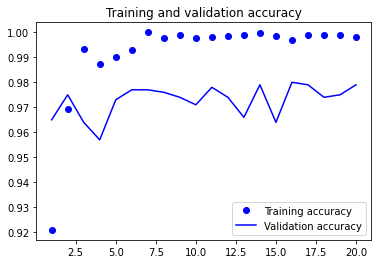

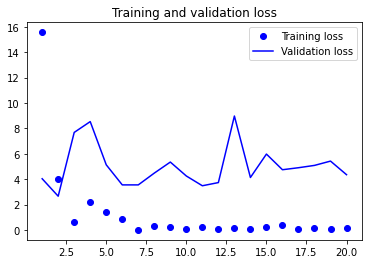

In [50]:
import matplotlib.pyplot as plt

acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, "bo", label="Training accuracy")
plt.plot(epochs, val_acc, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

这里直接达到了 97% 的验证准确率.但是这并不是普遍情况,毕竟 imgaeNet 中包含了大量猫狗图片.

看图片几乎一开始就过拟合了,添加 50% 的 Dropout 层也没起到太大作用.


In [51]:
test_model = keras.models.load_model("feature_extraction.keras")
test_loss, test_acc = test_model.evaluate(test_features, test_labels)
print(f"Test accuracy: {test_acc:.3f}")

63/63 [==============================] - 0s 2ms/step - loss: 4.7168 - accuracy: 0.9685
Test accuracy: 0.969


在测试集上的准确率达到了 96.9%


### 使用数据增强的特征提取

第二种方式算是直接复用预处理模型,构建成一个处理原始图片的模型,重新训练.

这样的模型训练要慢很多,训练的代价要高很多,但是这样可以使用数据增强.


在构建模型前,我们需要先冻结预处理模型的参数.在训练时阻止其权重更新,如果不这样做,密集层的权重是随机初始化的,可能带来巨大的梯度更新,有可能破坏预处理模型已经学习到的模式.


In [52]:
conv_base = keras.applications.vgg16.VGG16(weights="imagenet",
                                           include_top=False)
conv_base.trainable = False

In [53]:
conv_base.trainable = True
print(
    "This is the number of trainable weights "
    "before freezing the conv base:", len(conv_base.trainable_weights))


This is the number of trainable weights before freezing the conv base: 26


In [54]:
conv_base.trainable = False
print(
    "This is the number of trainable weights "
    "after freezing the conv base:", len(conv_base.trainable_weights))


This is the number of trainable weights after freezing the conv base: 0


`trainable` 属性设置为 `False` 是清空这个模型/层的可训练权重.


In [55]:
data_augmentation = keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal"),
    layers.experimental.preprocessing.RandomRotation(0.1),
    layers.experimental.preprocessing.RandomZoom(0.2),
])

inputs = keras.Input(shape=(180, 180, 3))
x = data_augmentation(inputs)  #数据增强
x = conv_base(x)  #预处理模型卷积层
x = layers.Flatten()(x)  #展开到1d
x = layers.Dense(256)(x)  #全连接层
x = layers.Dropout(0.5)(x)  #dropout
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs, outputs)
model.compile(loss="binary_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"])

模型

- 数据增强层
- 预处理模型的 cnn 层,被冻结.
- 密集层的分类器


In [56]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="feature_extraction_with_data_augmentation.keras",  #模型保存
        save_best_only=True,  #只保存在验证集上性能最好的模型
        monitor="val_loss")  #监控val_loss
]
history = model.fit(
    train_dataset,
    epochs=50,  #迭代 50 轮
    validation_data=validation_dataset,
    callbacks=callbacks)


Epoch 1/50
63/63 [==============================] - 8s 116ms/step - loss: 21.3244 - accuracy: 0.8640 - val_loss: 7.9641 - val_accuracy: 0.9430
Epoch 2/50
63/63 [==============================] - 7s 114ms/step - loss: 11.6734 - accuracy: 0.9095 - val_loss: 7.1791 - val_accuracy: 0.9570
Epoch 3/50
63/63 [==============================] - 7s 115ms/step - loss: 9.0616 - accuracy: 0.9255 - val_loss: 6.6029 - val_accuracy: 0.9550
Epoch 4/50
63/63 [==============================] - 7s 115ms/step - loss: 8.0140 - accuracy: 0.9275 - val_loss: 6.1276 - val_accuracy: 0.9530
Epoch 5/50
63/63 [==============================] - 7s 115ms/step - loss: 5.8148 - accuracy: 0.9365 - val_loss: 13.1466 - val_accuracy: 0.9230
Epoch 6/50
63/63 [==============================] - 7s 115ms/step - loss: 6.0796 - accuracy: 0.9445 - val_loss: 5.2201 - val_accuracy: 0.9630
Epoch 7/50
63/63 [==============================] - 7s 115ms/step - loss: 5.0212 - accuracy: 0.9420 - val_loss: 8.4935 - val_accuracy: 0.9380
Epo

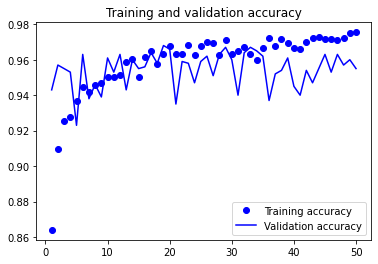

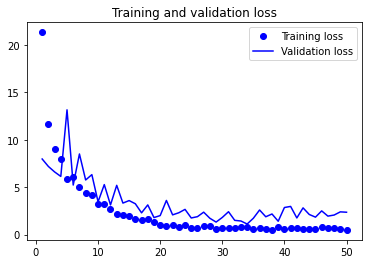

In [57]:
import matplotlib.pyplot as plt

acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, "bo", label="Training accuracy")
plt.plot(epochs, val_acc, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

In [58]:
test_model = keras.models.load_model(
    "feature_extraction_with_data_augmentation.keras")
test_loss, test_acc = test_model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")


63/63 [==============================] - 5s 73ms/step - loss: 1.3818 - accuracy: 0.9630
Test accuracy: 0.963


有点尴尬,最终测试集的准确率是 96.3% 比上一小节的 96.9% 还低了一点.这并不奇怪, imageNet 已经包含了大量猫狗图片.


## 微调模型

特征提取,比单纯自行训练的模型好很多,但是还不是极限.使用预处理模型的另一个技术是微调模型.

毕竟预处理的模型是在其他训练集上训练的,针对的也多是不同的问题.微调模型包括解冻模型一部分 layer,重新训练.这样算是微调模型使与问题更加匹配.

![vgg16_fine_tuning](vgg16_fine_tuning.png)


这里仅仅是解冻一小部分 layer 而且是直接和添加的层直接接触的部分.

微调模型,如同字面的意思,是对解冻部分微调,上一节提到的冻结的理由在这里依旧生效,不可能直接将解冻部分和全连接层一起训练.全连接层的分类器必须先训练完毕,才能进行微调.

- 在已训练好的网络(基网络)上添加自定义网络
- 冻结基网络
- 训练添加的部分网络
- 解冻基网络一部分
- 联合训练解冻网络和添加的网络.

截至到上一小节的代码,我们进行到了第 3 步了.


In [59]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_9 (InputLayer)         [(None, None, None, 3)]   0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, None, None, 128)   0     

现在这是预训练网络的样子.

我们需要先解冻全体,再冻结除 block5_conv1 block5_conv2  block5_conv3 外的所有层.

为什么只解冻 block5_conv1 block5_conv2  block5_conv3?

当然可以解冻更多层,但是这里并不合适.

- VGG16 是一个相当大的模型,卷积基有 1500 万参数,而我们的数据有限.如果解冻更多层,在小数据集上训练,非常容易过拟合.
- 卷积层距离密集层更远的 layer 代表了复用性更强的特征,距离密集层越近的 layer 代表了更专业特征.(或者说深度越浅,层代表的模式和训练数据越接近,深度越深,layer 的模式越与训练数据无关),更专业的模式与训练数据关联跟大,微调的回报越低.

在这里的情况下,只对直接与全连接层直接接触的 2~3 层进程微调是合适的.


In [61]:
conv_base.trainable = True  #解冻全部
for layer in conv_base.layers[:-4]:  #冻结除最好 3+1 层外其他
    layer.trainable = False

In [62]:
model.compile(
    loss="binary_crossentropy",  #损失函数
    optimizer=keras.optimizers.RMSprop(learning_rate=1e-5),  #优化器
    metrics=["accuracy"])  #指标


优化器换用了非常低的学习率,这对应只想对模型进行微调,限制参数的修改.


In [63]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="fine_tuning.keras",  #模型保存
        save_best_only=True,  #只保存在验证集上性能最好的模型
        monitor="val_loss")  #监控val_loss
]
history = model.fit(
    train_dataset,
    epochs=30,  #迭代 30 轮
    validation_data=validation_dataset,
    callbacks=callbacks)


Epoch 1/30
63/63 [==============================] - 10s 134ms/step - loss: 0.7035 - accuracy: 0.9760 - val_loss: 2.0006 - val_accuracy: 0.9660
Epoch 2/30
63/63 [==============================] - 8s 129ms/step - loss: 0.5482 - accuracy: 0.9805 - val_loss: 2.2635 - val_accuracy: 0.9620
Epoch 3/30
63/63 [==============================] - 8s 129ms/step - loss: 0.4447 - accuracy: 0.9810 - val_loss: 2.3709 - val_accuracy: 0.9570
Epoch 4/30
63/63 [==============================] - 8s 129ms/step - loss: 0.2185 - accuracy: 0.9840 - val_loss: 2.1624 - val_accuracy: 0.9640
Epoch 5/30
63/63 [==============================] - 8s 129ms/step - loss: 0.3893 - accuracy: 0.9835 - val_loss: 2.1808 - val_accuracy: 0.9670
Epoch 6/30
63/63 [==============================] - 8s 130ms/step - loss: 0.3213 - accuracy: 0.9855 - val_loss: 2.0551 - val_accuracy: 0.9640
Epoch 7/30
63/63 [==============================] - 8s 130ms/step - loss: 0.3268 - accuracy: 0.9855 - val_loss: 2.0496 - val_accuracy: 0.9590
Epoch

In [64]:
model = keras.models.load_model("fine_tuning.keras")
test_loss, test_acc = model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

63/63 [==============================] - 5s 73ms/step - loss: 1.6557 - accuracy: 0.9655
Test accuracy: 0.965


😂 请允许我使用这个表情..比 96.3% 提高了 0.2%...

没办法复现原书 98.5% 的准确率.


while 以上就是在小样本集处理图片分类问题的全过程.
